# Generating Similarity Scores and Matrix
### **Mean and Cosine Similarity(each event with all other event-types)**


In [5]:
import pickle
#import logging
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.pipeline import make_pipeline
from scipy import sparse
import numpy as np
import os.path
import re
from tqdm import tqdm
import warnings
import pandas as pd

In [7]:
infile = open('pickle','rb')
data = pickle.load(infile)
infile.close()
info = data.drop(['eventID','eventType','postID','postPriority','postText', 'processed_text'], axis=1)
#priorities = priorities.transpose()

In [9]:
info_types = ['Location', 'MultimediaShare', 'ContextualInformation', 'Weather', 'Discussion', 'Hashtags', 'News', 'Official', 'EmergingThreats', 'FirstPartyObservation', 'Factoid', 'ThirdPartyObservation', 'MovePeople', 'Sentiment', 'Advice', 'GoodsServices', 'Donations', 'ServiceAvailable', 'SearchAndRescue', 'NewSubEvent', 'Volunteer', 'CleanUp', 'InformationWanted', 'OriginalEvent']
(info_types)

['Location',
 'MultimediaShare',
 'ContextualInformation',
 'Weather',
 'Discussion',
 'Hashtags',
 'News',
 'Official',
 'EmergingThreats',
 'FirstPartyObservation',
 'Factoid',
 'ThirdPartyObservation',
 'MovePeople',
 'Sentiment',
 'Advice',
 'GoodsServices',
 'Donations',
 'ServiceAvailable',
 'SearchAndRescue',
 'NewSubEvent',
 'Volunteer',
 'CleanUp',
 'InformationWanted',
 'OriginalEvent']

In [10]:
for j in info_types:
    filename = j
    outfile = open(filename,'wb')
    r = -1
    df = pd.DataFrame()

    for i in info['postCategories']:
        r += 1
        if j in i:
            df = df.append(info.iloc[r])
            df['postCategories'] = j
    pickle.dump(df,outfile)
    outfile.close()

In [11]:
#1
infile = open('Location','rb')
Location = pickle.load(infile)
infile.close()
#2
infile = open('MultimediaShare','rb')
MultimediaShare = pickle.load(infile)
infile.close()
#3
infile = open('ContextualInformation','rb')
ContextualInformation = pickle.load(infile)
infile.close()
#4
infile = open('Weather','rb')
Weather = pickle.load(infile)
infile.close()
#5
infile = open('Discussion','rb')
Discussion = pickle.load(infile)
infile.close()
#6
infile = open('Hashtags','rb')
Hashtags = pickle.load(infile)
infile.close()
#7
infile = open('News','rb')
News = pickle.load(infile)
infile.close()
#8
infile = open('Official','rb')
Official = pickle.load(infile)
infile.close()
#9
infile = open('EmergingThreats','rb')
EmergingThreats = pickle.load(infile)
infile.close()
#10
infile = open('FirstPartyObservation','rb')
FirstPartyObservation = pickle.load(infile)
infile.close()
#11
infile = open('Factoid','rb')
Factoid = pickle.load(infile)
infile.close()
#12
infile = open('ThirdPartyObservation','rb')
ThirdPartyObservation = pickle.load(infile)
infile.close()
#13
infile = open('MovePeople','rb')
MovePeople = pickle.load(infile)
infile.close()
#14
infile = open('Sentiment','rb')
Sentiment = pickle.load(infile)
infile.close()
#15
infile = open('Advice','rb')
Advice = pickle.load(infile)
infile.close()
#16
infile = open('GoodsServices','rb')
GoodsServices = pickle.load(infile)
infile.close()
#17
infile = open('Donations','rb')
Donations = pickle.load(infile)
infile.close()
#18
infile = open('ServiceAvailable','rb')
ServiceAvailable = pickle.load(infile)
infile.close()
#19
infile = open('SearchAndRescue','rb')
SearchAndRescue = pickle.load(infile)
infile.close()
#20
infile = open('NewSubEvent','rb')
NewSubEvent = pickle.load(infile)
infile.close()
#21
infile = open('Volunteer','rb')
Volunteer = pickle.load(infile)
infile.close()
#22
infile = open('CleanUp','rb')
CleanUp = pickle.load(infile)
infile.close()
#23
infile = open('InformationWanted','rb')
InformationWanted = pickle.load(infile)
infile.close()
#24
infile = open('OriginalEvent','rb')
OriginalEvent = pickle.load(infile)
infile.close()

In [12]:
dataframes = [Location, MultimediaShare, ContextualInformation, Weather, Discussion, Hashtags, News, Official, EmergingThreats, FirstPartyObservation, Factoid, ThirdPartyObservation, MovePeople, Sentiment, Advice, GoodsServices, Donations, ServiceAvailable, SearchAndRescue, NewSubEvent, Volunteer, CleanUp, InformationWanted, OriginalEvent]

In [13]:
frame = pd.DataFrame(columns = ['postCategories', 'sbert_emb'])

for i in dataframes:
    frame = frame.append(i)
    
frame

,postCategories,sbert_emb
602,Location,"[0.28595802, 1.8915048, 0.55441177, -0.9483588..."
604,Location,"[-0.98355895, 0.28966317, -0.46716905, -0.3054..."
605,Location,"[-0.15513411, -1.2664062, -0.39587763, -1.2604..."
606,Location,"[-0.22859125, 0.7158369, 0.5458465, -0.2751035..."
607,Location,"[0.18250313, 0.37942246, -0.2061751, 0.1632700..."
...,...,...
91255,OriginalEvent,"[0.36215582, -0.073628835, 0.42149878, 2.01558..."
91289,OriginalEvent,"[-1.1156131, -0.6364583, 0.40808445, -0.119731..."
91403,OriginalEvent,"[-0.34107, -0.88236266, 0.3985841, -0.47163767..."
91465,OriginalEvent,"[0.36215582, -0.073628835, 0.42149878, 2.01558..."


In [14]:
filename = 'info_ranks'
outfile = open(filename,'wb')
pickle.dump(frame,outfile)
outfile.close()

In [17]:
from numpy import dot
from numpy.linalg import norm
import seaborn as sns

In [18]:
def generate_similarity_matrix (frame, grouping, group_types):
    #generate similarity scores dataframe
    group_ranks=pd.DataFrame()
    for heldout_event in group_types:

        training = frame[frame[grouping] != heldout_event]
        test = frame[frame[grouping] == heldout_event]

        ref=np.mean(test["sbert_emb"], axis=0)

        grpups=training.groupby(grouping) #Might    for heldout_event in info_types:
        ranks={} #empty dict
        ranks["reference-group"]=heldout_event
        for name, group in grpups:
            val=np.mean(group["sbert_emb"], axis=0)
            cos_sim = dot(ref, val)/(norm(ref)*norm(val))
            ranks[name]=cos_sim

        # event_ranks[heldout_event]=ranks
        #print(ranks)
        group_ranks = group_ranks.append(ranks, ignore_index=True) #creating the first column to compare the rest of the values to
    group_ranks.set_index("reference-group",inplace=True) #replaces index numbers
    #group_ranks=frame.groupby(grouping) #Does the label==1 need to change?
    return group_ranks

In [20]:
info_ranks = generate_similarity_matrix(frame, 'postCategories', info_types) #check what this variable is called in the dataframe
info_ranks = info_ranks.replace(np.nan, 1)
info_ranks.to_csv("info_ranks.csv")
info_ranks

,Advice,CleanUp,ContextualInformation,Discussion,Donations,EmergingThreats,Factoid,FirstPartyObservation,GoodsServices,Hashtags,...,News,Official,OriginalEvent,SearchAndRescue,Sentiment,ServiceAvailable,ThirdPartyObservation,Volunteer,Weather,Location
reference-group,,,,,,,,,,,,,,,,,,,,,
Location,0.906401,0.921598,0.913796,0.945039,0.685339,0.964750,0.977644,0.961568,0.805031,0.976123,...,0.993297,0.952683,0.956097,0.844527,0.894956,0.834890,0.979574,0.744743,0.923021,1.000000
MultimediaShare,0.895983,0.916664,0.922245,0.947750,0.682072,0.953523,0.975882,0.954310,0.800095,0.968555,...,0.993838,0.946378,0.956806,0.839858,0.887788,0.837823,0.984874,0.744619,0.909110,0.997795
ContextualInformation,0.894740,0.843935,1.000000,0.976525,0.706070,0.844526,0.882538,0.917561,0.806180,0.886741,...,0.939800,0.930510,0.872645,0.797350,0.865573,0.901229,0.916591,0.812094,0.779504,0.913796
Weather,0.850117,0.888680,0.779504,0.836810,0.631723,0.955577,0.901614,0.919294,0.748173,0.934027,...,0.896567,0.887288,0.845777,0.795499,0.799666,0.747932,0.848906,0.671389,1.000000,0.923021
Discussion,0.920715,0.871282,0.976525,1.000000,0.711269,0.889983,0.909858,0.957497,0.825147,0.932038,...,0.955888,0.940130,0.899251,0.822435,0.912561,0.890763,0.937562,0.805435,0.836810,0.945039
Hashtags,0.930740,0.924235,0.886741,0.932038,0.728810,0.961621,0.945717,0.978118,0.831723,1.000000,...,0.963607,0.949075,0.944075,0.858153,0.925974,0.846160,0.928779,0.780979,0.934027,0.976123
News,0.906486,0.908845,0.939800,0.955888,0.673414,0.950576,0.971922,0.955667,0.793925,0.963607,...,1.000000,0.965635,0.957288,0.840302,0.890924,0.845527,0.981021,0.751770,0.896567,0.993297
Official,0.938785,0.877734,0.930510,0.940130,0.680810,0.935032,0.919745,0.949330,0.783543,0.949075,...,0.965635,1.000000,0.904156,0.816878,0.868145,0.872523,0.916142,0.776271,0.887288,0.952683
EmergingThreats,0.906363,0.903950,0.844526,0.889983,0.646901,1.000000,0.936196,0.945738,0.781347,0.961621,...,0.950576,0.935032,0.907503,0.823671,0.864761,0.777698,0.914630,0.704435,0.955577,0.964750


In [22]:
info_ranks = pd.read_csv("final_info_ranks.csv", index_col = 0)
event_ranks = pd.read_csv('final_event_ranks.csv', index_col = 0)
critical_ranks = pd.read_csv("critical_ranks.csv")

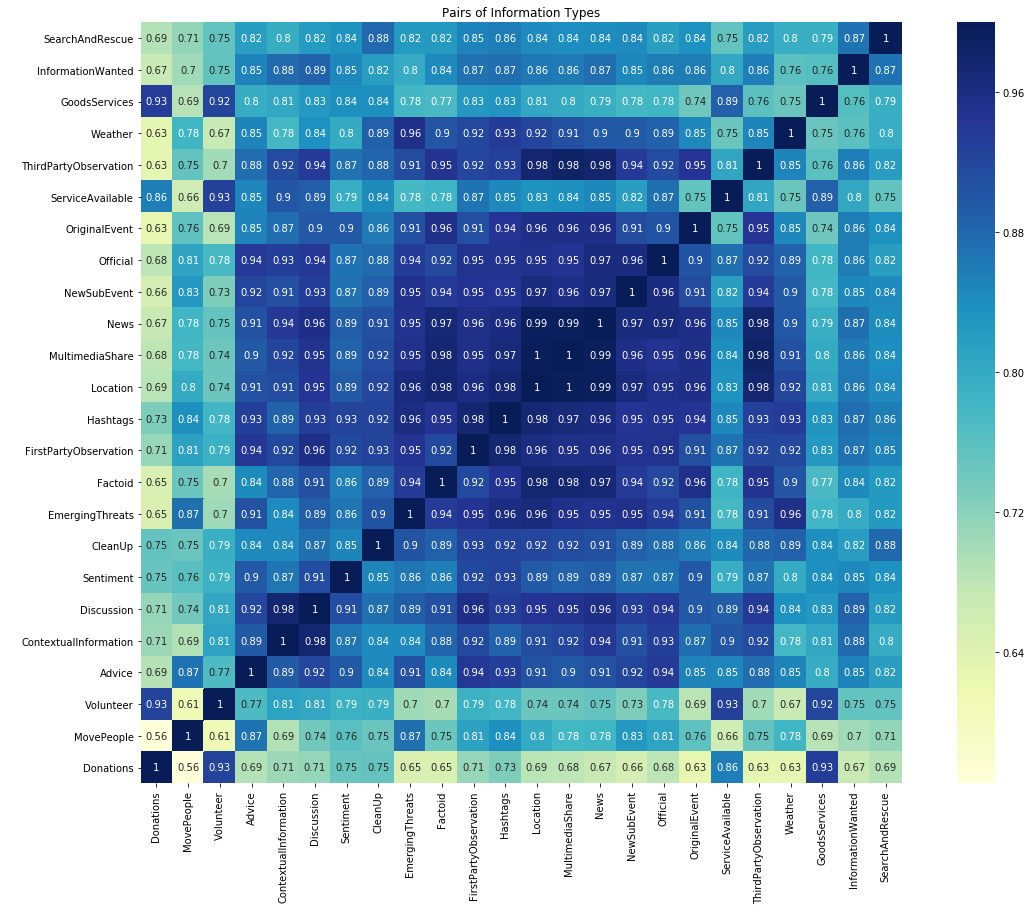

In [23]:
#Info types

import matplotlib.pyplot as plt

plt.figure(figsize=(20,14))

ax = plt.axes()

ax.set_title('Pairs of Information Types')

sns.heatmap(info_ranks, ax=ax,cmap="YlGnBu", annot=True, square=True)
plt.ylabel(' ')
#sns.heatmap(dt_tweet_cnt, ax=ax2)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

plt.show()

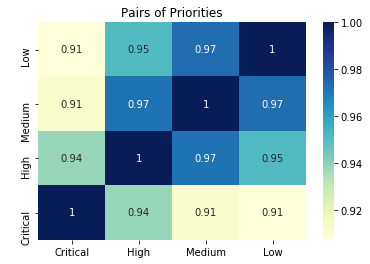

'3.1.1'

In [84]:
import matplotlib.pyplot as plt
ax = plt.axes()

ax.set_title('Pairs of Priorities')
sns.heatmap(critical_ranks, ax=ax,cmap="YlGnBu", annot=True)
plt.ylabel(' ')
#sns.heatmap(dt_tweet_cnt, ax=ax2)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

import matplotlib
matplotlib.__version__

In [4]:
event_ranks_final = pd.read_csv("event_ranks_final.csv", index_col = 0)
event_ranks_final

FileNotFoundError: [Errno 2] File b'event_ranks_final.csv' does not exist: b'event_ranks_final.csv'

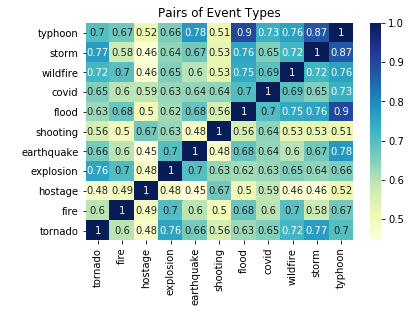

In [126]:
# Visualize similarity matrix for event type using heatmap

import matplotlib.pyplot as plt
ax = plt.axes()

ax.set_title('Pairs of Event Types')
sns.heatmap(event_ranks_final, ax=ax,cmap="YlGnBu", annot=True)
plt.ylabel(' ')
#sns.heatmap(dt_tweet_cnt, ax=ax2)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!